## Wireshark data process code

In [83]:
from csv import DictReader
from os import chdir
from binascii import a2b_hex

Set filter strings

In [84]:
pub_ip = '10.0.2.4'
sub_ip = '10.0.2.15'
broker_ip = '3.81.217.129'
msg_str = '[tempreture]'

Change work path
Set publisher and subscriber data path

In [85]:
work_path = r'C:\Users\yuxiang\OneDrive\出国\Study\CSYE6510\assignment 3\data'
chdir(work_path)
pub_data_path = '.\\pub2\\'
sub_data_path = '.\\sub2\\'

Set publisher data files' path

In [86]:
pub_qos0_path = pub_data_path+ 'qos0\\'
pub_qos1_path = pub_data_path+ 'qos1\\'
pub_qos2_path = pub_data_path+ 'qos2\\'

pub_qos0_0_path = pub_qos0_path + '1000_0loss.csv'
pub_qos0_5_path = pub_qos0_path + '1000_5loss.csv'
pub_qos0_10_path = pub_qos0_path + '1000_10loss.csv'

pub_qos1_0_path = pub_qos1_path + '1000_0loss.csv'
pub_qos1_5_path = pub_qos1_path + '1000_5loss.csv'
pub_qos1_10_path = pub_qos1_path + '1000_10loss.csv'

pub_qos2_0_path = pub_qos2_path + '1000_0loss.csv'
pub_qos2_5_path = pub_qos2_path + '1000_5loss.csv'
pub_qos2_10_path = pub_qos2_path + '1000_10loss.csv'

Set subsriber data files' path

In [87]:
sub_qos0_path = sub_data_path+ 'qos0\\'
sub_qos1_path = sub_data_path+ 'qos1\\'
sub_qos2_path = sub_data_path+ 'qos2\\'

sub_qos0_0_path = sub_qos0_path + '1000_0loss.csv'
sub_qos0_5_path = sub_qos0_path + '1000_5loss.csv'
sub_qos0_10_path = sub_qos0_path + '1000_10loss.csv'

sub_qos1_0_path = sub_qos1_path + '1000_0loss.csv'
sub_qos1_5_path = sub_qos1_path + '1000_5loss.csv'
sub_qos1_10_path = sub_qos1_path + '1000_10loss.csv'

sub_qos2_0_path = sub_qos2_path + '1000_0loss.csv'
sub_qos2_5_path = sub_qos2_path + '1000_5loss.csv'
sub_qos2_10_path = sub_qos2_path + '1000_10loss.csv'

Function for process csv data:
- Data of QoS level 1 or 2
- Data of Qos level 0 with no packet loss

In [88]:
def qos_csv_reader(csv_path_str, source_ip, dest_ip, contains_info):
    latency_array = []
    with open(csv_path_str, newline='') as csvfile:
        reader = DictReader(csvfile)
        for row in reader:
            if (source_ip in row['Source']) and (dest_ip in row['Destination'] and ('MQTT' == row['Protocol'])):
                for i in range(row['Info'].count(contains_info)):
                    latency_array.append(float(row['Time']))
                # When packet loss occurs with QoS 0, publisher will lose its mqtt publish msg
                # and show info as '[TCP Previous segment not captured] , Disconnect Req'
                if '[TCP Previous segment not captured]' in row['Info']:
                    latency_array.append(float(row['Time']))
#     print(csv_path_str + ' : ' + str(len(latency_array)))
    return latency_array

Function for process csv data:
- Data of Qos level 0 with packet loss
Add a column of mqtt.msg in WireShark so as to export msg data into csv file
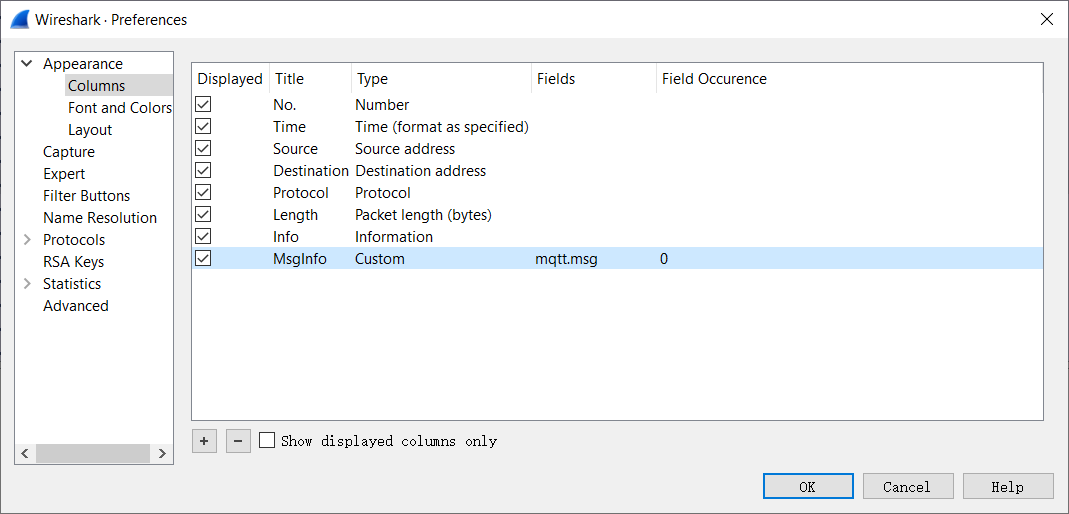

Function for get tempreture value from hex string
eg: '41404043' -> '100C' -> 100

In [89]:
def get_tempreture_num( msg_str ):
    return int(a2b_hex(msg_str.encode()).decode()[:-1])

Function for process csv data which has mqtt.msg field

**Because QoS 0 with packet loss will cause subscribed or published msgs arranged in the wrong order**

In [90]:
def qos0_loss_csv_reader(csv_path_str, source_ip, dest_ip, contains_info):
    res_dict = {}
    lost_timestamps = []
    lost_index = [i for i in range(1000)]
    with open(csv_path_str, newline='') as csvfile:
        reader = DictReader(csvfile)
        last_tempreture_num = 0
        for row in reader:
            if (source_ip in row['Source']) and (dest_ip in row['Destination'] and ('MQTT' == row['Protocol'])):
                msg_num = row['Info'].count(contains_info)
                info = row['MsgInfo']
                if msg_num > 1:
                    info_arr = info.split(',')
                    if(len(info_arr)==msg_num):
                        for hex_str in info_arr:
                            index = get_tempreture_num(hex_str)
                            res_dict.setdefault(index,float(row['Time']))
                            lost_index.remove(index)
                    else:
                        print("error!")
                elif msg_num == 1:
                    index = get_tempreture_num(info)
                    res_dict.setdefault(index,float(row['Time']))
                    lost_index.remove(index)
                elif '[TCP Previous segment not captured]' in row['Info']:
                    lost_timestamps.append(float(row['Time']))
    if len(lost_index) == len(lost_timestamps) and len(lost_timestamps) > 0:
        for index, timestamp in zip(lost_index, lost_timestamps):
            res_dict.setdefault(index, timestamp)
    res_dict = sorted(res_dict.items())
    latency_array = [b for a,b in res_dict ]
#     print(csv_path_str + ' : ' + str(len(latency_array)))
    return latency_array

Process publisher data to get timestamp lists for each case

In [91]:
pub_qos0_0_data = qos_csv_reader(pub_qos0_0_path, pub_ip, broker_ip, msg_str)
pub_qos0_5_data = qos0_loss_csv_reader(pub_qos0_5_path, pub_ip, broker_ip, msg_str)
pub_qos0_10_data = qos0_loss_csv_reader(pub_qos0_10_path, pub_ip, broker_ip, msg_str)

pub_qos1_0_data = qos_csv_reader(pub_qos1_0_path, pub_ip, broker_ip, msg_str)
pub_qos1_5_data = qos_csv_reader(pub_qos1_5_path, pub_ip, broker_ip, msg_str)
pub_qos1_10_data = qos_csv_reader(pub_qos1_10_path, pub_ip, broker_ip, msg_str)

pub_qos2_0_data = qos_csv_reader(pub_qos2_0_path, pub_ip, broker_ip, msg_str)
pub_qos2_5_data = qos_csv_reader(pub_qos2_5_path, pub_ip, broker_ip, msg_str)
pub_qos2_10_data = qos_csv_reader(pub_qos2_10_path, pub_ip, broker_ip, msg_str)

Process subsriber data to get timestamp lists for each case

In [92]:
sub_qos0_0_data = qos_csv_reader(sub_qos0_0_path, broker_ip, sub_ip, msg_str)
sub_qos0_5_data = qos0_loss_csv_reader(sub_qos0_5_path, broker_ip, sub_ip, msg_str)
sub_qos0_10_data = qos0_loss_csv_reader(sub_qos0_10_path, broker_ip, sub_ip, msg_str)

sub_qos1_0_data = qos_csv_reader(sub_qos1_0_path, broker_ip, sub_ip, msg_str)
sub_qos1_5_data = qos_csv_reader(sub_qos1_5_path, broker_ip, sub_ip, msg_str)
sub_qos1_10_data = qos_csv_reader(sub_qos1_10_path, broker_ip, sub_ip, msg_str)

sub_qos2_0_data = qos_csv_reader(sub_qos2_0_path, broker_ip, sub_ip, msg_str)
sub_qos2_5_data = qos_csv_reader(sub_qos2_5_path, broker_ip, sub_ip, msg_str)
sub_qos2_10_data = qos_csv_reader(sub_qos2_10_path, broker_ip, sub_ip, msg_str)

Function for calculate latency

In [93]:
def calculate_latency(pub_time_arr, sub_time_arr):
    avg_res = 0;
    native_case_num = 0
    index = 0
    if len(pub_time_arr) == len(sub_time_arr):
        latency_arr = []
        for pub,sub in zip(pub_time_arr,sub_time_arr):
            if (sub - pub) > 0:
                latency_arr.append(sub-pub)
            else:
                print("%d : %f - %f" % (index, sub, pub))
                native_case_num += 1
            index += 1
        avg_res = sum(latency_arr)/len(latency_arr)
    else:
        print("Length of input lists are not equal！")
    if native_case_num > 0:
        print("Native latency orrcurs %d times!" % native_case_num)
    return avg_res

Get latency result of each case

In [94]:
print("Qos 0 with 0%%  packet loss latency: %f s" % calculate_latency(pub_qos0_0_data,sub_qos0_0_data))
print("Qos 0 with 5%%  packet loss latency: %f s" % calculate_latency(pub_qos0_5_data,sub_qos0_5_data))
print("Qos 0 with 10%% packet loss latency: %f s" % calculate_latency(pub_qos0_10_data,sub_qos0_10_data))

print("Qos 1 with 0%%  packet loss latency: %f s" % calculate_latency(pub_qos1_0_data,sub_qos1_0_data))
print("Qos 1 with 5%%  packet loss latency: %f s" % calculate_latency(pub_qos1_5_data,sub_qos1_5_data))
print("Qos 1 with 10%% packet loss latency: %f s" % calculate_latency(pub_qos1_10_data,sub_qos1_10_data))

print("Qos 2 with 0%%  packet loss latency: %f s" % calculate_latency(pub_qos2_0_data,sub_qos2_0_data))
print("Qos 2 with 5%%  packet loss latency: %f s" % calculate_latency(pub_qos2_5_data,sub_qos2_5_data))
print("Qos 2 with 10%% packet loss latency: %f s" % calculate_latency(pub_qos2_10_data,sub_qos2_10_data))

Qos 0 with 0%  packet loss latency: 0.068281 s
Qos 0 with 5%  packet loss latency: 0.099493 s
Qos 0 with 10% packet loss latency: 0.119493 s
Qos 1 with 0%  packet loss latency: 0.067730 s
Qos 1 with 5%  packet loss latency: 0.068319 s
Qos 1 with 10% packet loss latency: 0.068085 s
Qos 2 with 0%  packet loss latency: 0.137305 s
Qos 2 with 5%  packet loss latency: 0.155797 s
Qos 2 with 10% packet loss latency: 0.185261 s


## Data Summary
1. Packet loss caused some of msgs under QoS 0 disordered both on subsriber and publisher.
2. Packet loss caused the obvious proportional increase of latency under QoS 0.
3. QoS 1 Level communication under packet loss maintains stable and less latency than all other QoS level.
4. QoS 2 level communication under packet loss caused small proportional increase on latency and has more stable latency then QoS 0 has.